In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #data visualization
import seaborn as sns  #data visualization
from scipy import stats #Stats library
from pylab import rcParams


#Matplotlib runtime(rc) configuration options
rcParams['figure.figsize'] = 11, 9



#Coerce warning issues
import warnings
warnings.filterwarnings('ignore')



#importing time-based libraries
import time
from datetime import time

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

#Libraries for statistical visualization in time-series
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Manipulating time series data**

In [2]:
#Some of the resourceful methods are pd.to_datetime(convert data type to datettime), pd.asfreq(for resampling) and pd.date_range(a range of dates)
#Typical time-series shifting may include - shifting or lagging values back or forward in time, getting the values for a given time period, and computing the percent change
#over many number of periods

**Reading in the data and basic formatting**

In [3]:
sunspots = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv', sep=',', parse_dates=True)

In [4]:
sunspots.head()

,Month,Sunspots
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0


In [5]:
sunspots['Month'] = pd.to_datetime(sunspots['Month'])
sunspots.set_index('Month')

,Sunspots
Month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0
...,...
1983-08-01,71.8
1983-09-01,50.3
1983-10-01,55.8


In [6]:
sunspots.tail()

,Month,Sunspots
2815,1983-08-01,71.8
2816,1983-09-01,50.3
2817,1983-10-01,55.8
2818,1983-11-01,33.3
2819,1983-12-01,33.4


# Visualization of a time-series, and summary stats and diagnostics

In [7]:
med_value = sunspots['Sunspots'].median()
quant_25 = sunspots['Sunspots'].quantile(0.25)
quant_99 = sunspots['Sunspots'].quantile(0.99)

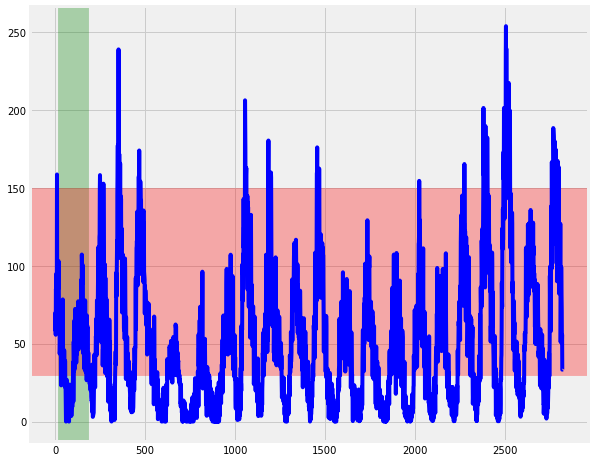

In [8]:
#Setting up the style of background grid
fig = plt.figure()
plt.style.use('fivethirtyeight')
ax = sunspots['Sunspots'].plot(color='blue', fontsize=10, figsize=(10, 8))


#A horizontal span
ax.axvspan(quant_25, quant_99, color='green', alpha=0.3)

#A vertical span
ax.axhspan(30, 150, color='red', alpha=0.3)

In [9]:
#Checking if there are any null values
sunspots.isnull().sum()

Month       0
Sunspots    0
dtype: int64

There aren't any null values in the dataframe

**Window Functions:**
1. Used to identify sub-periods, calculates sub-metrics of sub-periods.
2. Rolling - same size and sliding
3. Expanding - includes all previous values

In [10]:
#Setting the index back to datetime format
sunspots = sunspots.set_index('Month')

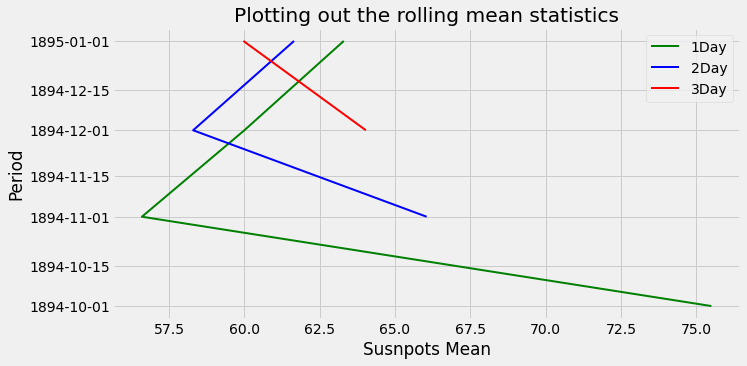

In [11]:
#Rolling mean visualizations of some section of data, say from 1749 to 1753, unable to understand the concept
sunSome_part = sunspots[1749 : 1753]


sunSome_mean1 = sunSome_part.rolling(1).mean() #rolling mean for a single month
sunSome_mean2 = sunSome_part.rolling(2).mean() #rolling mean for 2 consecutive months
sunSome_mean3 = sunSome_part.rolling(3).mean() #rolling mean for a period of 3 months

# ax = sunSome_mean1.plot()
# ax.set_xlabel('Date')
# ax.set_ylabel('Rolling Mean Variation')
# ax.set_title('SPOT statistics')

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(1, figsize=(10, 5))

ax.plot(sunSome_mean1, sunSome_mean1.index, linewidth=2, markersize=12, color='green')
ax.plot(sunSome_mean2, sunSome_mean2.index, linewidth=2, markersize=12, color='blue')
ax.plot(sunSome_mean3, sunSome_mean3.index, linewidth=2, markersize=12, color='red')

plt.title('Plotting out the rolling mean statistics')
plt.xlabel('Susnpots Mean')
plt.ylabel('Period')
plt.legend(['1Day', '2Day', '3Day'])

plt.show()

<Figure size 720x360 with 0 Axes>

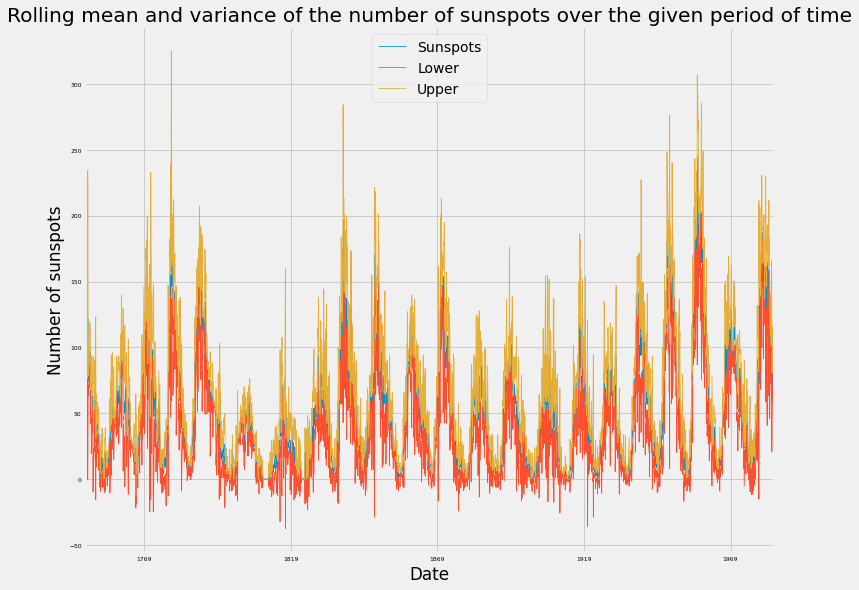

In [12]:
#Let's plot a more compact representation of our data. Here we will be computing rolling avergae for a lagging period of 2 months, i.e, 60 days.
#ma variable is for moving avergaes
ma = sunspots.rolling(window=2).mean()
mstd = sunspots.rolling(window=2).std()

#Adding the lower bound
ma['Lower'] = ma['Sunspots'] - (2 * mstd['Sunspots'])

#Adding the upper bound
ma['Upper'] = ma['Sunspots'] + (2 * mstd['Sunspots'])

#Plot the dataframe and set the labels
plt.figure(figsize=(10, 5))

ax = ma.plot(linewidth=0.8, fontsize=6)
plt.xlabel('Date')
plt.ylabel('Number of sunspots')
plt.xlabel('Date')
plt.title('Rolling mean and variance of the number of sunspots over the given period of time')

plt.show()

**Plotting aggregate values of a time series**

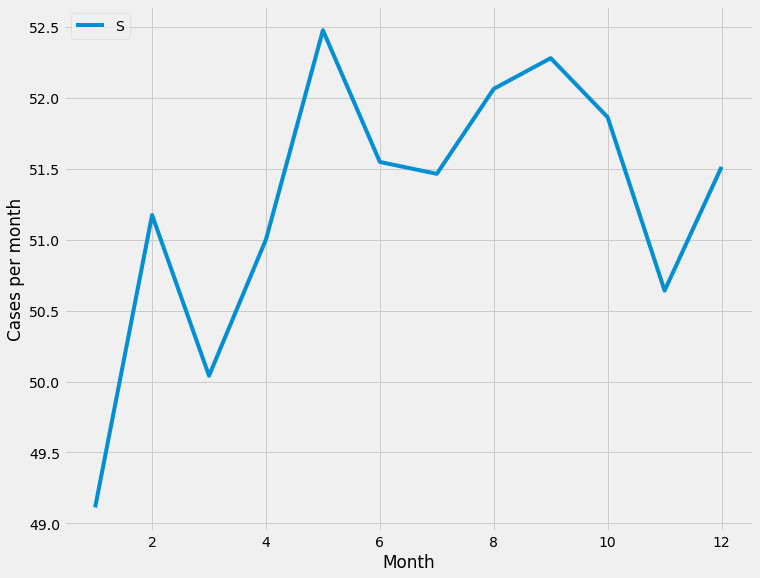

In [13]:
#For our use-case, let's try to plot the aggregate values for the number of spots in the year 1750
sunspots_1750 = sunspots.iloc[sunspots.index.year==1750, : ]
index_month = sunspots.index.month
sunspots_1750_by_month = sunspots.groupby(index_month).Sunspots.mean()

sunspots_1750_by_month.plot()
plt.ylabel('Cases per month')
plt.legend('Sunspots', loc='upper left')
plt.show()

Hence from the above visualization we can infer that the number of sunspots is at peak during the summer months,  which could be predetermindedly hypothesised.

Summarizing and plotting summary statistics

In [14]:
#Describing the dataframe
print(sunspots.describe())

#Minmimum value
print(sunspots['Sunspots'].min())

#Maximum value
print(sunspots['Sunspots'].max())

          Sunspots
count  2820.000000
mean     51.265957
std      43.448971
min       0.000000
25%      15.700000
50%      42.000000
75%      74.925000
max     253.800000
0.0
253.8


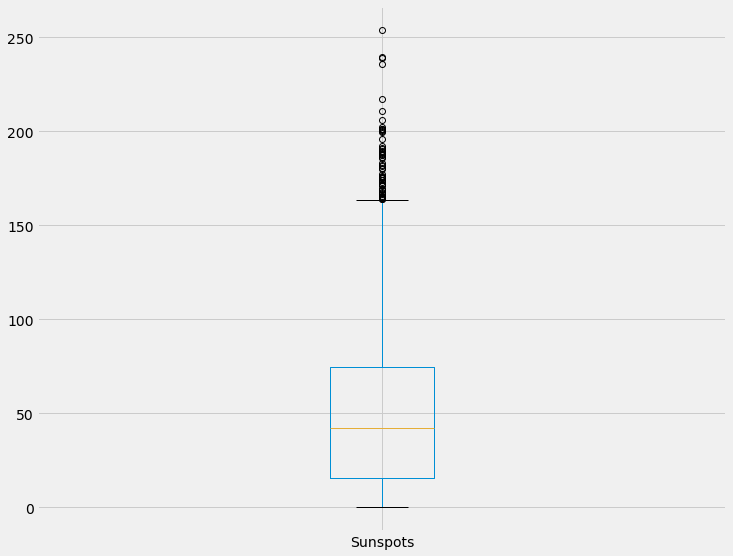

In [15]:
#Printing out the boxplot for visualizing summary statistics
boxplot = sunspots.boxplot()

In [16]:
sunspots_copy = sunspots.copy()
sunspots_copy.head()

,Sunspots
Month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0


In [17]:
sunspots_copy.rename(columns={'Month':'Date'}, inplace=True)

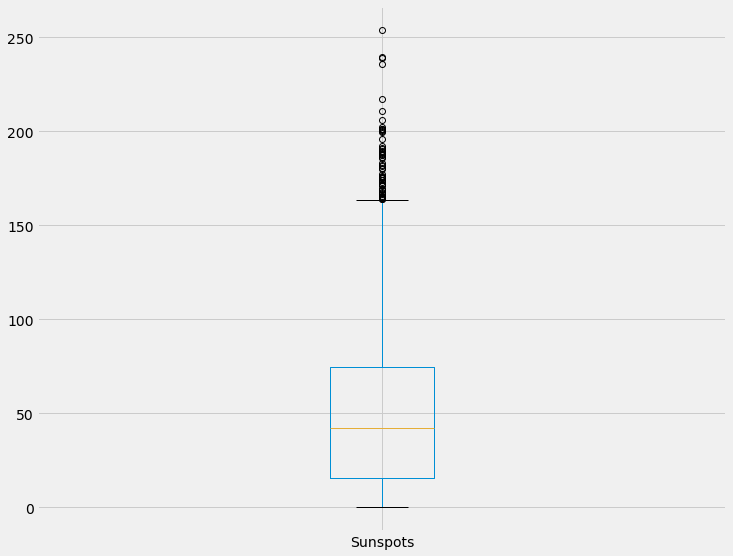

In [18]:
#Printing out the boxplot for visualizing summary statistics
boxplot = sunspots_copy.boxplot()

In [19]:
#We observe there are outliers in the upper half of boxplot. Let's reassign the outlier values to be equal to the upper half of the boxplot.
upper_perc = sunspots_copy['Sunspots'].quantile(0.75)
lower_perc = sunspots_copy['Sunspots'].quantile(0.25)

upper_limit = upper_perc + (3 * upper_perc)
lower_limit = lower_perc - (3 * lower_perc)

print(upper_limit)
print(lower_limit)

299.70000000000005
-31.399999999999995


In [20]:
#If the value of skewness is above 1, then it means there exists a positive skewness.
sunspots_copy['Sunspots'].skew()

1.1008858880635513

Histograms and Kernel Density Estimations(KDE):

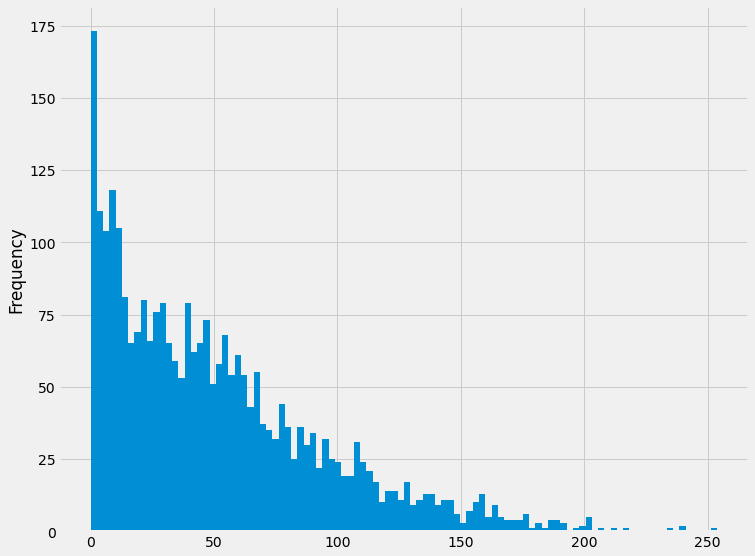

In [21]:
sunspots['Sunspots'].plot(kind='hist', bins=100)
plt.show()

In practice, histograms can be a substandard method for assessing the distribution of your data because they can be strongly affected by the number of bins that have been specified. Instead, kernel density plots represent a more effective way to view the distribution of your data. An example of how to generate a density plot of is shown below:

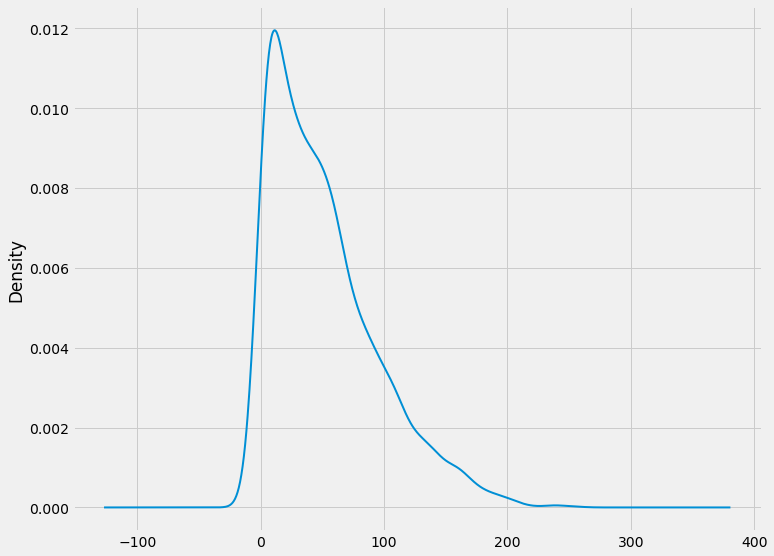

In [22]:
ax = sunspots['Sunspots'].plot(kind='density', linewidth=2)

In [23]:
#Since the distribution isn't normal, we will perform the following the quantile-based imputation
#sunspots_copy[sunspots_copy['Sunspots'] > upper_limit] = upper_limit

In [24]:
#There are a lot of negative values in the dataset. We need to remove them for the transformation to happen
#sunspots_copy['Sunspots-1'] = sunspots_copy[sunspots_copy['Sunspots'] > 0]

In [25]:
#Log-trasnform for removing left skewness
#sunspots_copy['Sunspots-1'] = np.log1p(sunspots_copy['Sunspots-1'])

In [26]:
#sunspots_copy['Sunspots-1'].plot(kind='hist', bins=100)
#plt.show()

In [27]:
#sunspots_copy.drop(['Sunspots'], axis=1, inplace=True)

In [28]:
#sunspots_copy['Sunspots-1'].plot(kind='kde')

Plotting autocorrelation and autocorrelation

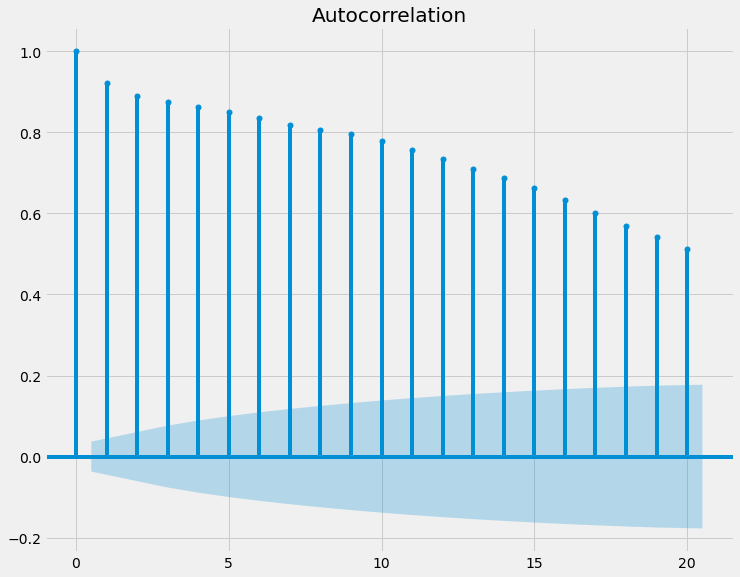

In [29]:
#Plotting autocorrelation
#Lags and alpha are the only important parameters in these plots
fig = plot_acf(sunspots_copy['Sunspots'], lags=20)
plt.show()

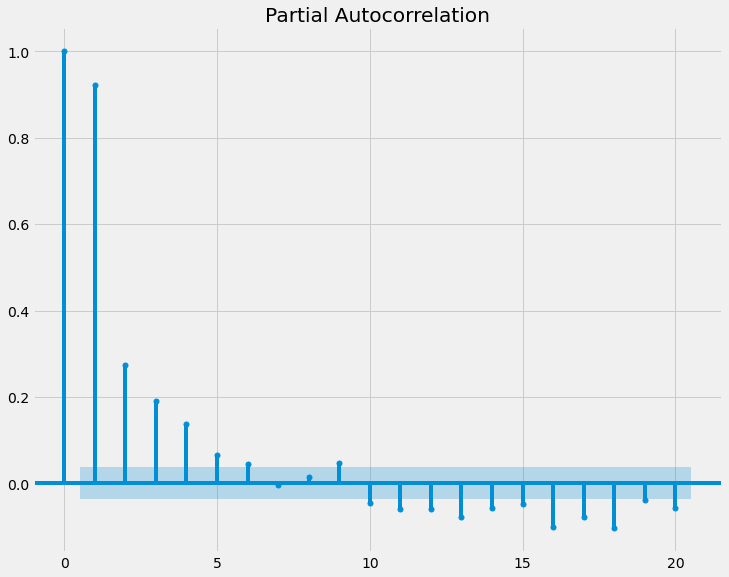

In [30]:
#Plotting partial autocorrelation
#Lags and alpha are the only important parameters in these plots
fig = plot_pacf(sunspots_copy['Sunspots'], lags=20)

Like autocorrelation, the partial autocorrelation function also measures the correlation coefficient between a time series and a lagged version of itself. But
the main difference between the two is that PACF smoothens(lessens variations) the effect of lags beyond the ones explicitly mentioned.

**Time Series Decomposition** - for visualizing trend, seasonality and noise

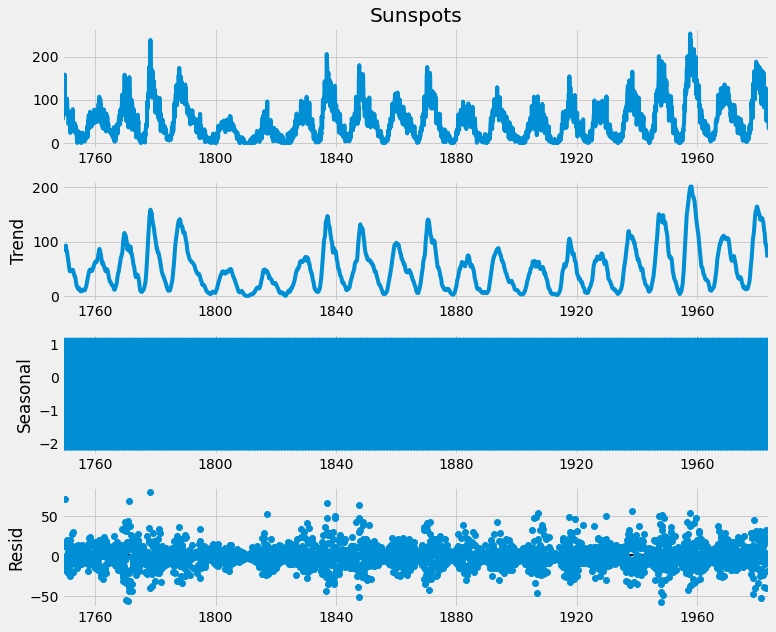

In [31]:
rcParams['figure.figsize'] = 11, 9

decomposition = seasonal_decompose(sunspots['Sunspots'])
figure = decomposition.plot()
plt.show()

In [32]:
print(dir(decomposition))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_observed', '_resid', '_seasonal', '_trend', '_weights', 'nobs', 'observed', 'plot', 'resid', 'seasonal', 'trend', 'weights']


In [33]:
print(decomposition.seasonal)

Month
1749-01-01   -2.161902
1749-02-01   -0.108501
1749-03-01   -1.275435
1749-04-01   -0.240018
1749-05-01    1.142211
                ...   
1983-08-01    0.756047
1983-09-01    1.068137
1983-10-01    0.622001
1983-11-01   -0.517030
1983-12-01    0.355156
Name: seasonal, Length: 2820, dtype: float64


Time Series decomposition is a powerful tool to reveal the structure in a time-series.

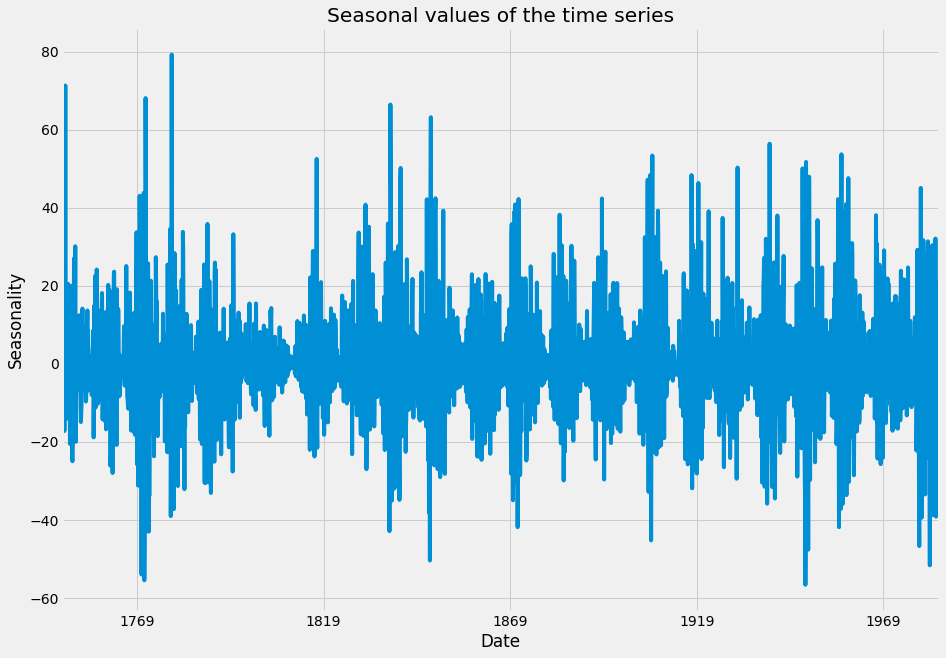

In [34]:
#A seasonal component(cyclic component) exists when a time-series is influenced by seasonal factors. 
decomp_seasonal = decomposition.resid
ax = decomp_seasonal.plot(figsize=(14, 10))
ax.set_xlabel('Date')
ax.set_ylabel('Seasonality')
ax.set_title('Seasonal values of the time series')
plt.show()

So far we have known:
1. Visualize aggregates of time series data
2. Extract statistical summaries
3. Autocorrelation and Partial autocorrelation
4. Time Series decomposition.

Multiple time-****series plots - refer the course

**Also you can print out the relationships between different time series data using heatmaps and clustered heatmaps.**
1. Create facetted plots and graphs(using the pandas .plot function and setting up the layout of plots
2. Set horiziontal/vertical lines/regions to specify/highlight some important year/date. This is ideal for a multiple time-series dataset.
3. Aggregate plots are also ideal for a time-series dataset. (Monthly or yearly trends) alongwith bbox_to_anchor)
4. Seasonal decomposition of multiple time-series togther.

Multiple time-series visualizations and code templates

> Time-Series Visualizations

In [35]:
# Plot all time series in the jobs DataFrame
# ax = jobs.plot(colormap='Spectral', fontsize=6, linewidth=0.8)
    
# Set labels and legend
# ax.set_xlabel('Date', fontsize=10)
# ax.set_ylabel('Unemployment Rate', fontsize=10)
# ax.set_title('Unemployment rate of U.S. workers by industry', fontsize=10)
# ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# Annotate your plots with vertical lines
# ax.axvline('2001-07-01', color='blue', linestyle='--', linewidth=0.8)
# ax.axvline('2008-09-01', color='blue', linestyle='--', linewidth=0.8)

# Show plot
# plt.show()

In [36]:
# Extract the seasonal values for the decomposition of each time series
# for ts in jobs_names:
#     jobs_seasonal[ts] = jobs_decomp[ts].seasonal
    
# Create a DataFrame from the jobs_seasonal dictionary
# seasonality_df = pd.DataFrame.from_dict(jobs_seasonal)

# Remove the label for the index
# seasonality_df.index.name = None

# Create a faceted plot of the seasonality_df DataFrame
# seasonality_df.plot(subplots=True,
#                    layout=(4, 4),
#                    sharey=False,
#                    fontsize=2,
#                    linewidth=0.3,
#                    legend=False)

# Show plot
# plt.show()

In [37]:
# Get correlation matrix of the seasonality_df DataFrame
# seasonality_corr = seasonality_df.corr(method='spearman')

# Customize the clustermap of the seasonality_corr correlation matrix
# fig = sns.clustermap(seasonality_corr, annot=True, annot_kws={"size": 4}, linewidths=.4, figsize=(15, 10))
# plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
# plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
# plt.show()

# Print the correlation between the seasonalities of the Government and Education & Health industries
# print(0.89)

In [38]:
#Unlabelling the indices
#The packages to be used are pandas, numpy, statsmodels and scipy for linear regression.

In [39]:
#Probable questions to be asked
#1. Do I need to resaqmple in my use-case?
#2. Do I need to apply percent changes in my use-case?
#3. 